In [228]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# machine learning models
from prophet import Prophet

In [229]:
#pip install "holidays==0.24" # may need this in order for prophet to work

In [230]:
# read df and clear
df = pd.read_csv(r"C:\Users\User\Downloads\Live_20210128.csv")

In [231]:
df

status_id status_type status_published  num_reactions  num_comments  \
0             1       video   4/22/2018 6:00            529           512   
1             2       photo  4/21/2018 22:45            150             0   
2             3       video   4/21/2018 6:17            227           236   
3             4       photo   4/21/2018 2:29            111             0   
4             5       photo   4/18/2018 3:22            213             0   
...         ...         ...              ...            ...           ...   
7045       7046       photo   9/24/2016 2:58             89             0   
7046       7047       photo  9/23/2016 11:19             16             0   
7047       7048       photo  9/21/2016 23:03              2             0   
7048       7049       photo   9/20/2016 0:43            351            12   
7049       7050       photo  9/10/2016 10:30             17             0   

      num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0            262        432         92         3          1         1   
1              0        150          0         0          0         0   
2             57        204         21         1          1         0   
3              0        111          0         0          0         0   
4              0        204          9         0          0         0   
...          ...        ...        ...       ...        ...       ...   
7045           0         89          0         0          0         0   
7046           0         14          1         0          1         0   
7047           0          1          1         0          0         0   
7048          22        349          2         0          0         0   
7049           0         17          0         0          0         0   

      num_angrys  Column1  Column2  Column3  Column4  
0              0      NaN      NaN      NaN      NaN  
1              0      NaN      NaN      NaN      NaN  
2              0      NaN      NaN      NaN      NaN  
3              0      NaN      NaN      NaN      NaN  
4              0      NaN      NaN      NaN      NaN  
...          ...      ...      ...      ...      ...  
7045           0      NaN      NaN      NaN      NaN  
7046           0      NaN      NaN      NaN      NaN  
7047           0      NaN      NaN      NaN      NaN  
7048           0      NaN      NaN      NaN      NaN  
7049           0      NaN      NaN      NaN      NaN  

[7050 rows x 16 columns]

#### Our dataframe looks good. We see that it has 7050 observations and 16 variables. The last 4 columns are empty. Let's drop them.

In [232]:
df = df.drop(["Column1", "Column2", "Column3", "Column4"], axis="columns")

In [233]:
df[df.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [status_id, status_type, status_published, num_reactions, num_comments, num_shares, num_likes, num_loves, num_wows, num_hahas, num_sads, num_angrys]
Index: []

#### There are no missing values.

In [234]:
# analysing the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   status_id         7050 non-null   int64 
 1   status_type       7050 non-null   object
 2   status_published  7050 non-null   object
 3   num_reactions     7050 non-null   int64 
 4   num_comments      7050 non-null   int64 
 5   num_shares        7050 non-null   int64 
 6   num_likes         7050 non-null   int64 
 7   num_loves         7050 non-null   int64 
 8   num_wows          7050 non-null   int64 
 9   num_hahas         7050 non-null   int64 
 10  num_sads          7050 non-null   int64 
 11  num_angrys        7050 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 661.1+ KB


#### We see that the status_type and status_published variables are of type "Object". We need to set them to numerical/datetime/categorical format in order to work with them. 

In [235]:
print(df["status_type"].value_counts())   # displaying all the status types that this variable contains. They are photo, video, status and link.
df["status_type"] = df["status_type"].astype("category")  # this variable is now categorical

status_type
photo     4288
video     2334
status     365
link        63
Name: count, dtype: int64


In [236]:
print(df["status_published"])  # status_published displays first the date and then the time of the publication
df["status_published"] = pd.to_datetime(df["status_published"]) # converting the values in the "status_published" to datetime objects

0        4/22/2018 6:00
1       4/21/2018 22:45
2        4/21/2018 6:17
3        4/21/2018 2:29
4        4/18/2018 3:22
             ...       
7045     9/24/2016 2:58
7046    9/23/2016 11:19
7047    9/21/2016 23:03
7048     9/20/2016 0:43
7049    9/10/2016 10:30
Name: status_published, Length: 7050, dtype: object


In [237]:
df.dtypes  #the newly assigned types of the variables

status_id                    int64
status_type               category
status_published    datetime64[ns]
num_reactions                int64
num_comments                 int64
num_shares                   int64
num_likes                    int64
num_loves                    int64
num_wows                     int64
num_hahas                    int64
num_sads                     int64
num_angrys                   int64
dtype: object

#### Now we will check for duplicates -> first checking if there are more than one of the same ID, then checking if observations have different IDs but the same information (the exact same time of publishing and so on)

In [238]:
df.nunique() #counting the number of unique values

status_id           7050
status_type            4
status_published    6913
num_reactions       1067
num_comments         993
num_shares           501
num_likes           1044
num_loves            229
num_wows              65
num_hahas             42
num_sads              24
num_angrys            14
dtype: int64

#### The status_ids are all different (all 7050), but there are more than one "status_published" at the exact same point of time (the value for "status_published" is only 6913) which is strange. We can assume that some of these observations are duplicates. We need to check if the other values for these observations are different in order to be sure whether they are duplocate.

In [239]:
df.drop("status_id", axis="columns").drop_duplicates()  

status_type    status_published  num_reactions  num_comments  num_shares  \
0          video 2018-04-22 06:00:00            529           512         262   
1          photo 2018-04-21 22:45:00            150             0           0   
2          video 2018-04-21 06:17:00            227           236          57   
3          photo 2018-04-21 02:29:00            111             0           0   
4          photo 2018-04-18 03:22:00            213             0           0   
...          ...                 ...            ...           ...         ...   
7045       photo 2016-09-24 02:58:00             89             0           0   
7046       photo 2016-09-23 11:19:00             16             0           0   
7047       photo 2016-09-21 23:03:00              2             0           0   
7048       photo 2016-09-20 00:43:00            351            12          22   
7049       photo 2016-09-10 10:30:00             17             0           0   

      num_likes  num_loves  num_wows  num_hahas  num_sads  num_angrys  
0           432         92         3          1         1           0  
1           150          0         0          0         0           0  
2           204         21         1          1         0           0  
3           111          0         0          0         0           0  
4           204          9         0          0         0           0  
...         ...        ...       ...        ...       ...         ...  
7045         89          0         0          0         0           0  
7046         14          1         0          1         0           0  
7047          1          1         0          0         0           0  
7048        349          2         0          0         0           0  
7049         17          0         0          0         0           0  

[6996 rows x 11 columns]

#### Here we dropped the variable "status_id". The function drop_duplicates drops all observations from the resulting data frame that are the same.

In [240]:
df = df[df.index.isin(df.drop("status_id", axis="columns").drop_duplicates().index)] # saving the dataframe without duplicates

# .index accesses the index of the resulting dataframe obtained after dropping the "status_id" column and removing duplicates
# df.index.isin(...): This creates a boolean mask by checking if each index value in the original df is present in the index of the newly obtained dataframe. This results in a Series of True and False values.
# The boolean mask is used to filter the original df. It keeps only the rows where the index is present in the index of the newly obtained dataframe

In [241]:
df 

status_id status_type    status_published  num_reactions  num_comments  \
0             1       video 2018-04-22 06:00:00            529           512   
1             2       photo 2018-04-21 22:45:00            150             0   
2             3       video 2018-04-21 06:17:00            227           236   
3             4       photo 2018-04-21 02:29:00            111             0   
4             5       photo 2018-04-18 03:22:00            213             0   
...         ...         ...                 ...            ...           ...   
7045       7046       photo 2016-09-24 02:58:00             89             0   
7046       7047       photo 2016-09-23 11:19:00             16             0   
7047       7048       photo 2016-09-21 23:03:00              2             0   
7048       7049       photo 2016-09-20 00:43:00            351            12   
7049       7050       photo 2016-09-10 10:30:00             17             0   

      num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0            262        432         92         3          1         1   
1              0        150          0         0          0         0   
2             57        204         21         1          1         0   
3              0        111          0         0          0         0   
4              0        204          9         0          0         0   
...          ...        ...        ...       ...        ...       ...   
7045           0         89          0         0          0         0   
7046           0         14          1         0          1         0   
7047           0          1          1         0          0         0   
7048          22        349          2         0          0         0   
7049           0         17          0         0          0         0   

      num_angrys  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
7045           0  
7046           0  
7047           0  
7048           0  
7049           0  

[6996 rows x 12 columns]

#### After cleaning, our data has 6996 observations and 12 variables.

### Statistical analysis

In [242]:
exclude_variable = 'status_id'
df_without_column = df.drop(columns=[exclude_variable])  # excluding status_id from the analysis
table_without_column = df_without_column.describe().round(2)
print(table_without_column)

                    status_published  num_reactions  num_comments  num_shares  \
count                           6996        6996.00       6996.00     6996.00   
mean   2016-11-16 06:45:15.737564416         225.09        225.65       40.28   
min              2012-07-15 02:51:00           0.00          0.00        0.00   
25%              2016-03-08 02:38:30          17.00          0.00        0.00   
50%              2017-11-17 01:04:30          58.00          4.00        0.00   
75%              2018-03-06 07:14:15         216.00         22.25        4.00   
max              2018-06-13 01:12:00        4710.00      20990.00     3424.00   
std                              NaN         452.95        892.92      132.07   

       num_likes  num_loves  num_wows  num_hahas  num_sads  num_angrys  
count    6996.00    6996.00   6996.00    6996.00   6996.00     6996.00  
mean      210.04      12.76      1.25       0.70      0.23        0.11  
min         0.00       0.00      0.00       0.00   

C:\Users\User\AppData\Local\Temp\ipykernel_13896\3027576823.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




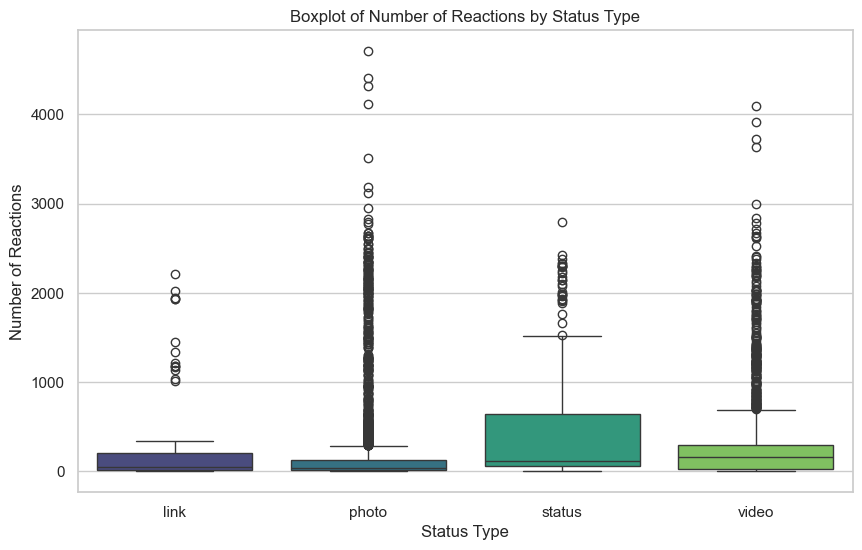

In [243]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(x='status_type', y='num_reactions', data=df, palette='viridis')

# Set plot labels and title
plt.xlabel('Status Type')
plt.ylabel('Number of Reactions')
plt.title('Boxplot of Number of Reactions by Status Type')

# Show the plot
plt.show()

#### These are boxplots for the number of reactions for each status type. We see that there are a lot of observations above the 75th percentile for photos and videos. It should be noted that the number of photos and video is a lot larger than that of links and statuses.

#### Let's look at the correlation between the numeric variables.

In [244]:
correlation_matrix = df.select_dtypes(["number"]).corr()
print(correlation_matrix)

               status_id  num_reactions  num_comments  num_shares  num_likes  \
status_id       1.000000      -0.207802      0.186255    0.210293  -0.230868   
num_reactions  -0.207802       1.000000      0.156146    0.259594   0.994671   
num_comments    0.186255       0.156146      1.000000    0.640524   0.105888   
num_shares      0.210293       0.259594      0.640524    1.000000   0.179614   
num_likes      -0.230868       0.994671      0.105888    0.179614   1.000000   
num_loves       0.157392       0.310600      0.521304    0.820277   0.212665   
num_wows        0.054703       0.261678      0.163493    0.409794   0.199996   
num_hahas       0.116399       0.179630      0.325051    0.399851   0.123100   
num_sads        0.036681       0.082065      0.257533    0.218613   0.057080   
num_angrys      0.097134       0.136038      0.239545    0.332343   0.096249   

               num_loves  num_wows  num_hahas  num_sads  num_angrys  
status_id       0.157392  0.054703   0.116399  0.

There is no point to look at the status_id. We will drop that and make the matrix prettier.

In [245]:
correlation_matrix_excluded = correlation_matrix.drop(exclude_variable).drop(exclude_variable, axis=1)

<Axes: >

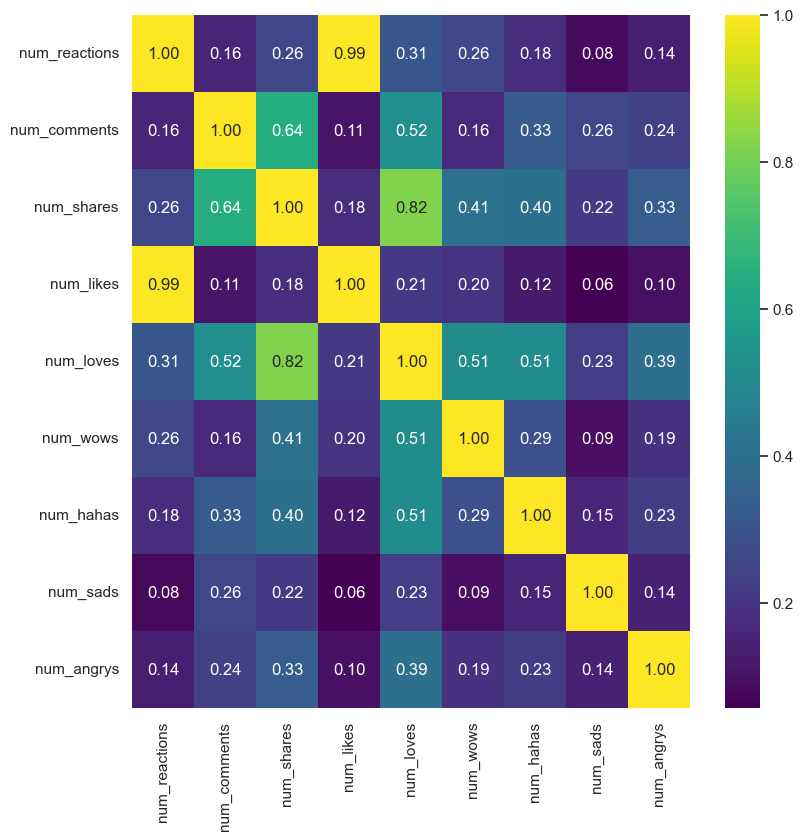

In [246]:
plt.figure(figsize = (9,9))
sns.heatmap(correlation_matrix_excluded, annot = True, fmt = ".2f", cmap = "viridis")

We can see that the correlation between likes and number of reactions is almost 1. This might be due to the fact that the most reactions are likes (num_reactions is the sum of all likes and reactions) and as such almost the whole information of number of likes is contained in the number of reactions. Also the 3 variables num_comments, num_shares and num_loves correlate between each other a lot.

#### We will now use parallel coordinates plots. In them each line represents one observation, and each vertical line segment represents a variable, in this case num_reactions, num_comments and num_shares. They can help us see the relationship between the variables and find outliers.

In [247]:
# Filter the DataFrame for "photo" status type
df_photo = df[df['status_type'] == 'photo']

dict_replace = {"photo": 1, "status": 2, "video": 3, "link": 4}

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_photo['status_type'].replace(dict_replace),
        colorscale=[[0, 'midnightblue'], [1, 'midnightblue']]
    ),
    dimensions=list([
        dict(label='Number of Reactions', values=df_photo['num_reactions']),
        dict(label='Number of Comments', values=df_photo['num_comments']),
        dict(label='Number of Shares', values=df_photo['num_shares'])
    ])
))

fig.update_layout(
    title='Photos',
    plot_bgcolor='white',
    paper_bgcolor='white'
)


We can clearly see a big outlier: a photo that has 0 reactions, 0 shares but over 10 000 comments. This is very suspicious. Assuming that this is a mistake, we will remove this outlier.

In [248]:
len(df)  # now our dataframe has 6996 observations

6996

In [249]:
df = df[df['num_comments'] != 10194]  # removing the observations with 10 194 comments

In [250]:
len(df)    # one less

6995

Let's look at statuses, videos and links.

In [251]:
# Filter the DataFrame for "status" status type
df_status = df[df['status_type'] == 'status']

dict_replace = {"photo": 1, "status": 2, "video": 3, "link": 4}

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_status['status_type'].replace(dict_replace),
        colorscale=[[0, 'lightskyblue'], [1, 'lightskyblue']]
    ),
    dimensions=list([
        dict(label='Number of Reactions', values=df_status['num_reactions']),
        dict(label='Number of Comments', values=df_status['num_comments']),
        dict(label='Number of Shares', values=df_status['num_shares'])
    ])
))

fig.update_layout(
    title='Statuses',
    plot_bgcolor='white',
    paper_bgcolor='white'
)



In [252]:
# Filter the DataFrame for "video" status type
df_video = df[df['status_type'] == 'video']

dict_replace = {"photo": 1, "status": 2, "video": 3, "link": 4}

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_video['status_type'].replace(dict_replace),
        colorscale=[[0, 'lightseagreen'], [1, 'lightseagreen']]
    ),
    dimensions=list([
        dict(label='Number of Reactions', values=df_video['num_reactions']),
        dict(label='Number of Comments', values=df_video['num_comments']),
        dict(label='Number of Shares', values=df_video['num_shares'])
    ])
))

fig.update_layout(
    title='Videos',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

There are some videos which have a very large number of comments: over 15 000, and a relatively small number of reactions and shares. Let's have a look:

In [253]:
df[(df['num_comments'] > 15000) & (df['status_type'] == 'video')]

status_id status_type    status_published  num_reactions  num_comments  \
480         481       video 2016-12-09 21:48:00            452         19013   
498         499       video 2016-11-30 08:46:00            564         20990   
6757       6758       video 2017-09-25 10:35:00            708         17404   

      num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
480          161        353         92         2          3         2   
498          154        473         82         3          3         3   
6757         913        525        157         6         14         4   

      num_angrys  
480            0  
498            0  
6757           2

The num_reactions and num_shares is not 0 or near that, so we will leave those observations.

In [254]:
# Filter the DataFrame for "link" status type
df_link = df[df['status_type'] == 'link']

dict_replace = {"photo": 1, "status": 2, "video": 3, "link": 4}

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_link['status_type'].replace(dict_replace),
        colorscale=[[0, 'rebeccapurple'], [1, 'rebeccapurple']]
    ),
    dimensions=list([
        dict(label='Number of Reactions', values=df_link['num_reactions']),
        dict(label='Number of Comments', values=df_link['num_comments']),
        dict(label='Number of Shares', values=df_link['num_shares'])
    ])
))

fig.update_layout(
    title='Links',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

### We will now dive deeper how engagement metrics evolved over time.

In [255]:
df = df.sort_values("status_published")   # sorts observations by the column status_published
# will not affect our model

In [256]:
fig = go.Figure()
fig.add_trace(go.Scatter(
   name="Number of Reactions",
   mode="lines", x=df["status_published"], y=df["num_reactions"], line={'width': 6}
))

fig.add_trace(go.Scatter(
   name="Number of Likes",
   mode="lines", x=df["status_published"], y=df["num_likes"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Loves",
   mode="lines", x=df["status_published"], y=df["num_loves"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Wows",
   mode="lines", x=df["status_published"], y=df["num_wows"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Hahas",
   mode="lines", x=df["status_published"], y=df["num_hahas"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Sads",
   mode="lines", x=df["status_published"], y=df["num_sads"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Angrys",
   mode="lines", x=df["status_published"], y=df["num_angrys"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Comments",
   mode="lines", x=df["status_published"], y=df["num_comments"], stackgroup = 'one'
))

fig.update_xaxes(rangeslider_visible=True,
                    rangeselector=dict(
       buttons=list([
           dict(count=7, label="1w", step="day", stepmode="backward"),
           dict(count=1, label="1m", step="month", stepmode="backward"),
           dict(count=6, label="6m", step="month", stepmode="backward"),
           dict(count=1, label="1y", step="year", stepmode="backward"),
           dict(step="all")
       ]))
)

fig.show()

#### If we remove the comments, we can see clearly that there were a lot of likes between 2014 and 2016. After the second half of 2017 they started to increase again. If we plot only number of loves, for example, it is evident that they are non-existent before February 2016. That is due to the fact that Facebook introduced globally reactions like loves, hahas, wows, etc on the 24th of February, 2016. 

#### Now we will investigate the relationship between our main engagement metric of interest, mainly num_reactions and different dimensions of time (hours, days, months). We will also group the results by type of status.

In [257]:
df_plot = df.copy()
df_plot["hour_dt"] = df["status_published"].dt.hour + 1
df_plot = df_plot.groupby(["hour_dt", "status_type"]).num_reactions.mean().reset_index()
df_plot = df_plot.sort_values(["status_type", "hour_dt"])
df_plot["hour_dt"] = df_plot["hour_dt"].astype("string")
fig = go.Figure()
# fig.add_trace(go.Scatterpolar(
#        r = df_plot["num_reactions"],
#        theta = df_plot["hour_dt"],
#        mode = 'lines',
#    ))

fig = px.line_polar(df_plot, r="num_reactions", theta="hour_dt", line_close=True, color="status_type", title = "Average Number of Reactions by Status Type grouped by hour")#
                   #color_discrete_sequence=px.colors.sequential.Plasma_r,)

fig.update_traces(fill='toself')

fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_13896\4061649688.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

d:\anaconda\envs\probe\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### The status and link plots look a little bit strange. This is highly likely to be due to the fact that the number of status_type which are status are only 365. The links are even fewer: only 63!

In [258]:
print(df["status_type"].value_counts())

status_type
photo     4241
video     2332
status     359
link        63
Name: count, dtype: int64


#### Let's look at the days of the week.

In [259]:
import plotly.express as px

df_plot = df.copy()
df_plot["hour_dt"] = df["status_published"].dt.day_of_week + 1
df_plot = df_plot.groupby(["hour_dt", "status_type"]).num_reactions.mean().reset_index()
df_plot = df_plot.sort_values(["status_type", "hour_dt"])
df_plot["hour_dt"] = df_plot["hour_dt"].astype("string")

custom_colors = ["rebeccapurple", "midnightblue", "lightskyblue", "lightseagreen"]

fig = px.bar(df_plot, x="hour_dt", y="num_reactions", color="status_type",
             title="Average Number of Reactions by Status Type grouped by day of week",
             category_orders={"hour_dt": ["1", "2", "3", "4", "5", "6", "7"]},
             color_discrete_sequence=custom_colors,
             text=df_plot["num_reactions"].round(0),  # Display values as whole numbers
             height=400  # Adjust the height of the plot as needed
            )

fig.update_layout(xaxis_title="Day of Week", yaxis_title="Average Number of Reactions")

# Label each bar plot according to the day of the week
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig.update_xaxes(tickvals=list(map(str, range(1, 8))), ticktext=day_labels)

fig.show()


C:\Users\User\AppData\Local\Temp\ipykernel_13896\451390641.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

d:\anaconda\envs\probe\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



The bar with Wednesday looks a lot bigger than the others, but when we remove links from the plot, the difference disappears. This makes sense because the number of links in the data is small and not representative.

In [260]:
import plotly.express as px

# Assuming 'status_published' is a datetime column
df['month'] = df['status_published'].dt.month

df_plot = df.groupby(['month', 'status_type']).num_reactions.mean().reset_index()

custom_colors = ["rebeccapurple", "midnightblue", "lightskyblue", "lightseagreen"]

fig = px.bar(df_plot, x="month", y="num_reactions", color="status_type",
             title="Average Number of Reactions by Status Type grouped by month",
             color_discrete_sequence=custom_colors,
             text=df_plot["num_reactions"].round(0),  # Display values as whole numbers
             height=400  # Adjust the height of the plot as needed
            )

fig.update_layout(xaxis_title="Month", yaxis_title="Average Number of Reactions")

fig.show()


C:\Users\User\AppData\Local\Temp\ipykernel_13896\2318982521.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

d:\anaconda\envs\probe\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Again, when we remove the links and statuses from the plot (by unclicking them on the right side of the plot), the difference is not very big. We can see that the number of reactions is lower in the winter months.

## Our solution: prophet model: very suitable for timeseries data

### Preparation for the model

#### We remove the reactions columns that came after 2016 because they will throw off the model, also the number of likes correlate a lot with the number of reactions so they will also be dropped. The status ID will also be dropped because it is just an integer. Our Y variable is num_reactions. Our X main variables are status_type and status_published. num_shares is also added, as shares can increase the market reach and lead to more reactions.

In [261]:
df_filtered = df.drop(["num_loves", "num_likes", "num_wows", "num_hahas", "num_sads", "num_angrys", "status_id"], axis = "columns")

#### One hot encoding for the status type

In [262]:
df_filtered = pd.get_dummies(df_filtered, columns = ["status_type"], dtype = "int")

In [263]:
df_filtered

status_published  num_reactions  num_comments  num_shares  month  \
2634 2012-07-15 02:51:00             15             3           0      7   
2633 2012-07-15 02:58:00             14             7           0      7   
2632 2012-07-15 03:32:00             14             1           0      7   
2631 2012-07-15 03:42:00             12             3           0      7   
2630 2012-07-15 03:54:00             19            17           3      7   
...                  ...            ...           ...         ...    ...   
4734 2018-06-12 22:55:00              9             0           1      6   
4733 2018-06-12 23:15:00              2             4           0      6   
4732 2018-06-13 00:58:00             97           177         210      6   
4731 2018-06-13 00:59:00             27             0          18      6   
4730 2018-06-13 01:12:00              2             0           0      6   

      status_type_link  status_type_photo  status_type_status  \
2634                 0                  1                   0   
2633                 0                  1                   0   
2632                 0                  1                   0   
2631                 0                  1                   0   
2630                 0                  1                   0   
...                ...                ...                 ...   
4734                 0                  1                   0   
4733                 0                  1                   0   
4732                 0                  0                   0   
4731                 0                  0                   0   
4730                 0                  1                   0   

      status_type_video  
2634                  0  
2633                  0  
2632                  0  
2631                  0  
2630                  0  
...                 ...  
4734                  0  
4733                  0  
4732                  1  
4731                  1  
4730                  0  

[6995 rows x 9 columns]

In [264]:
df_prophet = df_filtered.rename({"status_published" : "ds", "num_reactions" : "y"}, axis = "columns")[["ds", "y", "num_shares", "status_type_link", "status_type_photo", "status_type_status", "status_type_video"]]
# here we include num_shares as a predictor as well

We will split the data into a train and test part. For time series cross-validation, we want to maintain the temporal order of the data, which helps simulate the real-world scenario where you train the model on past data and evaluate it on future data. This is especially important because our data exhibits temporal patterns (a lot of reactions in 2015 and 2016, then few, then a big increase in the last years: visible on of our graphs). That is why we will use a simple procedure of dividing the data: before 15.03.2018, and after. A rule-of-thumb for this hold-out validation procedure is 80-20 or 70-30 percent. In our case, the train data will be 76,5% and the test data will be 23,5% of all observations. 
A larger training set can help the model learn better, especially if the dataset is small (our case). On the other hand, we still want a sufficient amount of data for testing to evaluate the model's performance accurately. That is why we chose this split.

In [265]:
reference_date = pd.to_datetime("15.03.2018") # Specifying the reference date
# Calculating the percentage of observations before the reference date
percentage_before_date = (df['status_published'] < reference_date).mean() * 100
percentage_after_date = (df['status_published'] > reference_date).mean() * 100
print(f"{percentage_before_date:.2f}% of observations are before {reference_date}")
print(f"{percentage_after_date:.2f}% of observations are after {reference_date}")

76.50% of observations are before 2018-03-15 00:00:00
23.50% of observations are after 2018-03-15 00:00:00


C:\Users\User\AppData\Local\Temp\ipykernel_13896\4080882810.py:1: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [266]:
df_train = df_prophet[df_prophet.ds <= pd.to_datetime("15.03.2018")]
df_test = df_prophet[df_prophet.ds > pd.to_datetime("15.03.2018")]

C:\Users\User\AppData\Local\Temp\ipykernel_13896\1436485736.py:1: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_13896\1436485736.py:2: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [267]:
m = Prophet()
m.add_regressor("num_shares")
m.add_regressor("status_type_link")
m.add_regressor("status_type_photo")
m.add_regressor("status_type_status")
m.add_regressor("status_type_video")
m.fit(df_train)

21:36:46 - cmdstanpy - INFO - Chain [1] start processing
21:36:48 - cmdstanpy - INFO - Chain [1] done processing


In [268]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

regressor regressor_mode     center  coef_lower       coef  \
0          num_shares       additive  25.725098    0.872767   0.872767   
1    status_type_link       additive   0.000000  -58.849095 -58.849095   
2   status_type_photo       additive   0.000000   30.984452  30.984452   
3  status_type_status       additive   0.000000   36.843410  36.843410   
4   status_type_video       additive   0.000000   24.268369  24.268369   

   coef_upper  
0    0.872767  
1  -58.849095  
2   30.984452  
3   36.843410  
4   24.268369

In [269]:
# make the datasets for plotting the results
forecast = m.predict(df_test.drop("y", axis = "columns"))
forecast2 = m.predict(pd.merge(m.make_future_dataframe(periods=0), df_prophet).drop("y", axis = "columns"))
test_points = pd.merge(forecast, df_test, on = "ds")
train_points = pd.merge(forecast2, df_train, on = "ds")

# remove everything below 0
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_points[col] = test_points[col].clip(lower=0.0)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_points[col] = train_points[col].clip(lower=0.0)

Text(0.5, 1.0, 'Prediction of Number of Reactions')

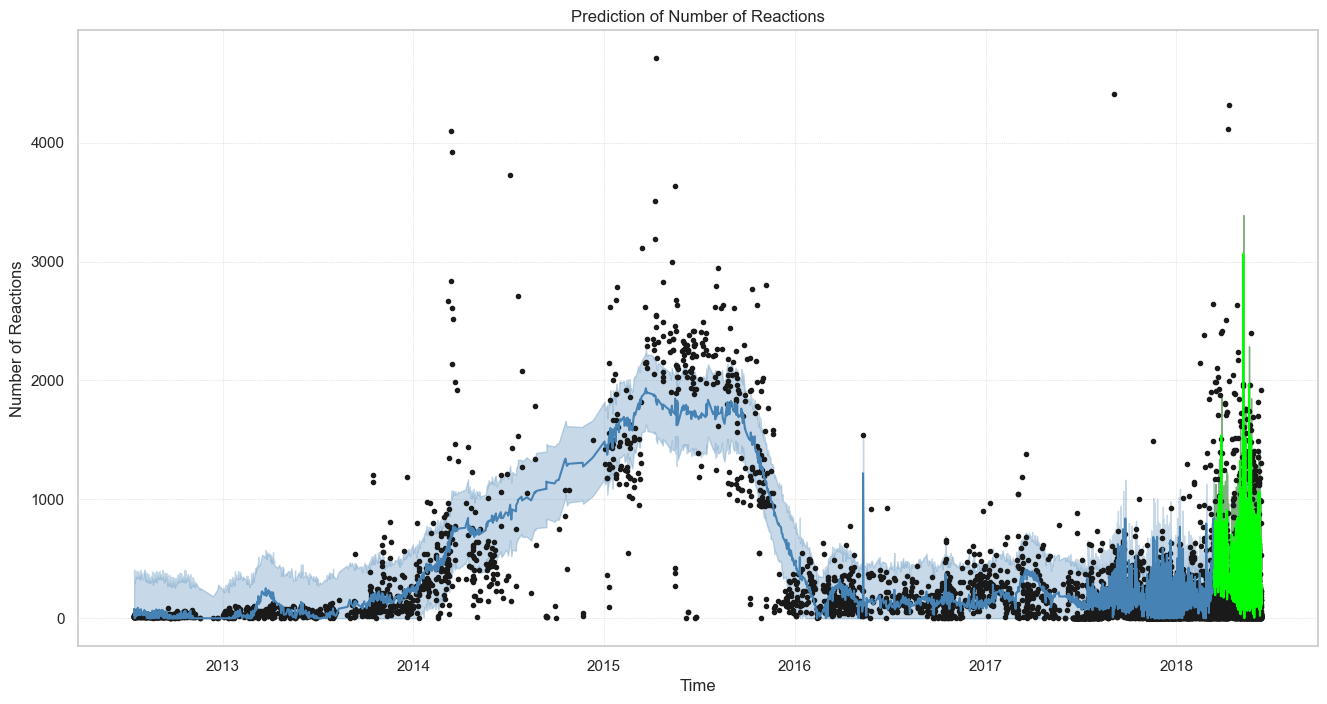

In [270]:
f, ax = plt.subplots(figsize=(16, 8))
ax.plot(train_points.ds, train_points.y, 'ko', markersize=3)
ax.plot(train_points.ds, train_points.yhat, color='steelblue', lw=1.5)
ax.fill_between(train_points.ds, train_points.yhat_lower, train_points.yhat_upper, color='steelblue', alpha=0.3)
ax.plot(test_points.ds, test_points.y, 'ko', markersize=3)
ax.plot(test_points.ds, test_points.yhat, color='lime', lw=1.5)
ax.fill_between(test_points.ds, test_points.yhat_lower, test_points.yhat_upper, color='darkgreen', alpha=0.5)
ax.grid(ls=':', lw=0.5)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Reactions")
ax.set_title("Prediction of Number of Reactions")

The black dots present the actual values, while the blue line shows the predicted ones. The steel blue lines represent the uncertainty intervals of the prediction. The plot below shows the effect of each component of the model and as such is capable to show the best to make a post.

d:\anaconda\envs\probe\lib\site-packages\prophet\plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\anaconda\envs\probe\lib\site-packages\prophet\plot.py:395: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\anaconda\envs\probe\lib\site-packages\prophet\plot.py:399: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\anaconda\envs\probe\lib\site-packages\prophet\plot.py:349: FutureWarning:

The beh

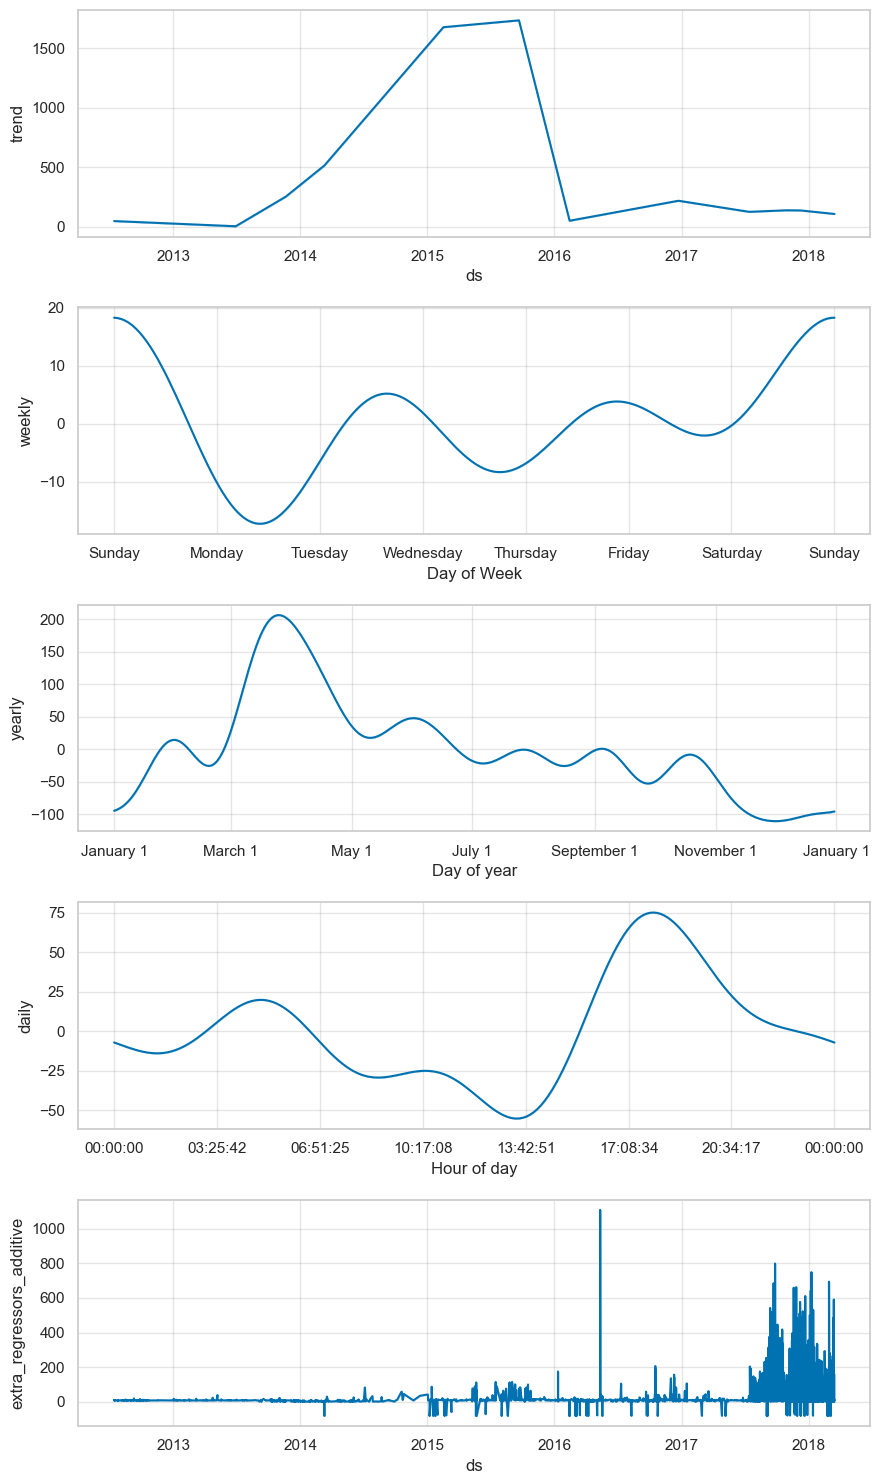

In [271]:
f = m.plot_components(forecast2)
plt.savefig("test.svg")

For comparing different models, we will mainly rely on Mean Absolute Error. MAE is more robust in the presence of outliers and doesn't magnify the impact of large errors as much as MSE. In time series forecasting, unexpected events or sudden changes might lead to outliers, and MAE can be more robust in such cases. MAE gives equal weight to all errors, making it less influenced by extreme values.

In [272]:
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import mean_squared_error, r2_score
mae(train_points.y, train_points.yhat)

121.48147898542157

In [296]:
mae(test_points.y, test_points.yhat)
mean_squared_error(test_points.y, test_points.yhat)
r2_score(test_points.y, test_points.yhat)

print(f"Mean Absolute Error on df_test: {mae(test_points.y, test_points.yhat):.2f}")

print(f'Mean squared error: {mean_squared_error(test_points.y, test_points.yhat):.2f}')

print(f'R2 score: {r2_score(test_points.y, test_points.yhat):.2f}')
print(f'R2 score of train: {r2_score(train_points.y, train_points.yhat):.2f}')

Mean Absolute Error on df_test: 216.42
Mean squared error: 131406.33
R2 score: 0.29
R2 score of train: 0.71


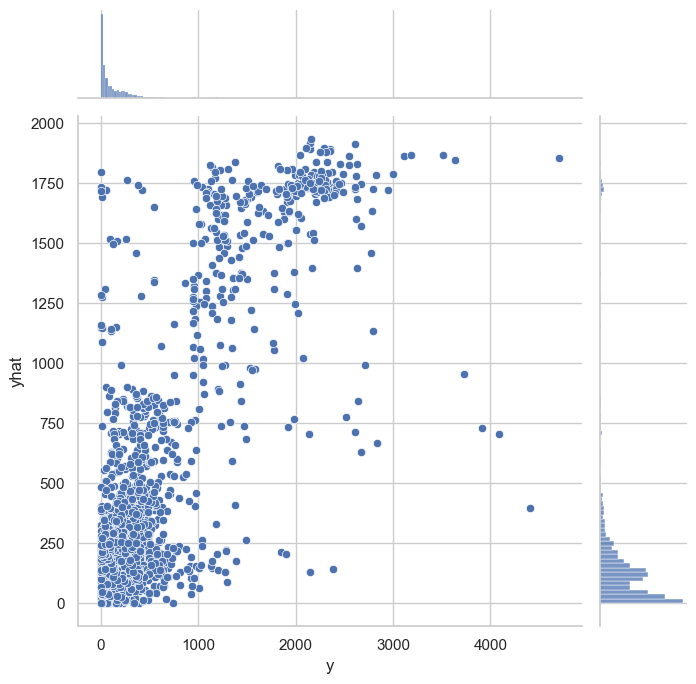

In [274]:
g = sns.jointplot(x="y", y="yhat", data=train_points, height=7)

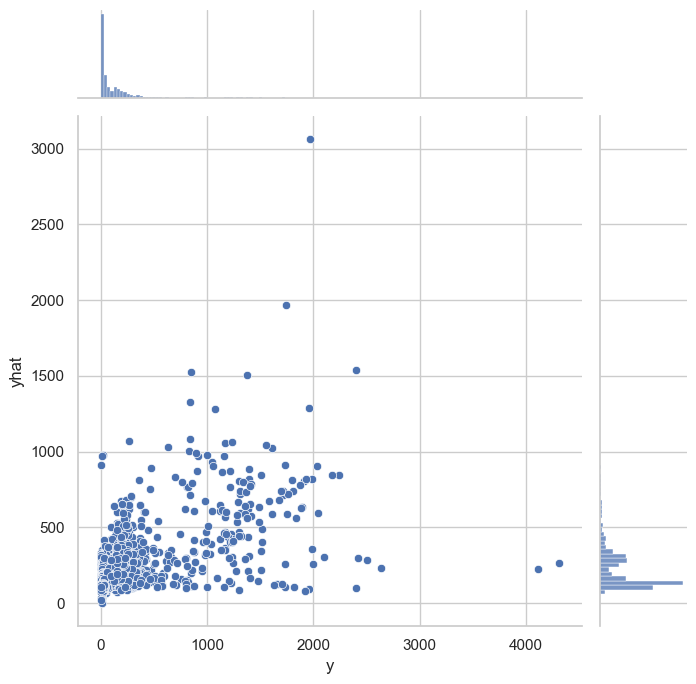

In [275]:
g = sns.jointplot(x="y", y="yhat", data=test_points, height=7)

#### Let's compare our model to other state-of-the-art aproaches, namely linear regression and random forest. 

## Regression

In order to do a regression, we need to set our time variable to many categorical ones. Based on our statistical analysis, we decided to include hour, month and year, because for these variables there was enough variation. For that, we need to create new variables indicating the hour and month and to do one-hot-encoding on them.

In [276]:
# Create a new variable with only the hour
df_filtered['hour'] = df_filtered['status_published'].dt.strftime('%H')

# Print the DataFrame to verify the new variable
print(df_filtered[['status_published', 'hour']])

        status_published hour
2634 2012-07-15 02:51:00   02
2633 2012-07-15 02:58:00   02
2632 2012-07-15 03:32:00   03
2631 2012-07-15 03:42:00   03
2630 2012-07-15 03:54:00   03
...                  ...  ...
4734 2018-06-12 22:55:00   22
4733 2018-06-12 23:15:00   23
4732 2018-06-13 00:58:00   00
4731 2018-06-13 00:59:00   00
4730 2018-06-13 01:12:00   01

[6995 rows x 2 columns]


In [277]:
# Create a new variable with the month as a string
df_filtered['month'] = df_filtered['status_published'].dt.strftime('%B')

# Print the DataFrame to verify the new variable
print(df_filtered[['status_published', 'month']])

        status_published month
2634 2012-07-15 02:51:00  July
2633 2012-07-15 02:58:00  July
2632 2012-07-15 03:32:00  July
2631 2012-07-15 03:42:00  July
2630 2012-07-15 03:54:00  July
...                  ...   ...
4734 2018-06-12 22:55:00  June
4733 2018-06-12 23:15:00  June
4732 2018-06-13 00:58:00  June
4731 2018-06-13 00:59:00  June
4730 2018-06-13 01:12:00  June

[6995 rows x 2 columns]


In [278]:
# Create a new variable with the year as a string
df_filtered['year'] = df_filtered['status_published'].dt.strftime('%Y')

# Print the DataFrame to verify the new variable
print(df_filtered[['status_published', 'year']])

        status_published  year
2634 2012-07-15 02:51:00  2012
2633 2012-07-15 02:58:00  2012
2632 2012-07-15 03:32:00  2012
2631 2012-07-15 03:42:00  2012
2630 2012-07-15 03:54:00  2012
...                  ...   ...
4734 2018-06-12 22:55:00  2018
4733 2018-06-12 23:15:00  2018
4732 2018-06-13 00:58:00  2018
4731 2018-06-13 00:59:00  2018
4730 2018-06-13 01:12:00  2018

[6995 rows x 2 columns]


We will now make dummy variables for each year, each month and each hour of the day.

In [279]:
df_filtered = pd.get_dummies(df_filtered, columns = ["year"], dtype = "int")

In [280]:
df_filtered = pd.get_dummies(df_filtered, columns = ["month"], dtype = "int")

In [281]:
df_filtered = pd.get_dummies(df_filtered, columns = ["hour"], prefix='hour', dtype = "int")

In [282]:
df_filtered

status_published  num_reactions  num_comments  num_shares  \
2634 2012-07-15 02:51:00             15             3           0   
2633 2012-07-15 02:58:00             14             7           0   
2632 2012-07-15 03:32:00             14             1           0   
2631 2012-07-15 03:42:00             12             3           0   
2630 2012-07-15 03:54:00             19            17           3   
...                  ...            ...           ...         ...   
4734 2018-06-12 22:55:00              9             0           1   
4733 2018-06-12 23:15:00              2             4           0   
4732 2018-06-13 00:58:00             97           177         210   
4731 2018-06-13 00:59:00             27             0          18   
4730 2018-06-13 01:12:00              2             0           0   

      status_type_link  status_type_photo  status_type_status  \
2634                 0                  1                   0   
2633                 0                  1                   0   
2632                 0                  1                   0   
2631                 0                  1                   0   
2630                 0                  1                   0   
...                ...                ...                 ...   
4734                 0                  1                   0   
4733                 0                  1                   0   
4732                 0                  0                   0   
4731                 0                  0                   0   
4730                 0                  1                   0   

      status_type_video  year_2012  year_2013  ...  hour_14  hour_15  hour_16  \
2634                  0          1          0  ...        0        0        0   
2633                  0          1          0  ...        0        0        0   
2632                  0          1          0  ...        0        0        0   
2631                  0          1          0  ...        0        0        0   
2630                  0          1          0  ...        0        0        0   
...                 ...        ...        ...  ...      ...      ...      ...   
4734                  0          0          0  ...        0        0        0   
4733                  0          0          0  ...        0        0        0   
4732                  1          0          0  ...        0        0        0   
4731                  1          0          0  ...        0        0        0   
4730                  0          0          0  ...        0        0        0   

      hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  
2634        0        0        0        0        0        0        0  
2633        0        0        0        0        0        0        0  
2632        0        0        0        0        0        0        0  
2631        0        0        0        0        0        0        0  
2630        0        0        0        0        0        0        0  
...       ...      ...      ...      ...      ...      ...      ...  
4734        0        0        0        0        0        1        0  
4733        0        0        0        0        0        0        1  
4732        0        0        0        0        0        0        0  
4731        0        0        0        0        0        0        0  
4730        0        0        0        0        0        0        0  

[6995 rows x 51 columns]

In [283]:
df_filtered.columns    # showing all variables

Index(['status_published', 'num_reactions', 'num_comments', 'num_shares',
       'status_type_link', 'status_type_photo', 'status_type_status',
       'status_type_video', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'year_2016', 'year_2017', 'year_2018', 'month_April', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'hour_00', 'hour_01', 'hour_02',
       'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08',
       'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [284]:
df_filtered = df_filtered.drop(['num_comments'], axis=1) 

We remove num_comments and num_shares as they might be influenced by status_type and status_published, which will throw off our simple linear model.

Splitting the data the same way as before:

In [285]:
df_train = df_filtered[df_filtered['status_published'] <= pd.to_datetime("15.03.2018")]
df_test = df_filtered[df_filtered['status_published'] > pd.to_datetime("15.03.2018")]

C:\Users\User\AppData\Local\Temp\ipykernel_13896\540875243.py:1: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_13896\540875243.py:2: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [286]:
# check if it is the same as before:
total_observations = len(df_filtered)
# Number of observations in df_train
num_train_observations = len(df_train)
# Number of observations in df_test
num_test_observations = len(df_test)
# Percentage calculations
percent_train = (num_train_observations / total_observations) * 100
percent_test = (num_test_observations / total_observations) * 100

print(f"Number of observations in df_train: {num_train_observations}")
print(f"Number of observations in df_test: {num_test_observations}")
print(f"Percentage of df_train from total: {percent_train:.2f}%")
print(f"Percentage of df_test from total: {percent_test:.2f}%")

Number of observations in df_train: 5351
Number of observations in df_test: 1644
Percentage of df_train from total: 76.50%
Percentage of df_test from total: 23.50%


The split is the same as in our prophet model. Now, let's do the regression on the train data.

In [320]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Specify the X variables
features = ['status_type_link', 'status_type_photo', 'status_type_status',
            'status_type_video', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
            'year_2016', 'year_2017', 'year_2018', 'month_April', 'month_August',
            'month_December', 'month_February', 'month_January', 'month_July',
            'month_June', 'month_March', 'month_May', 'month_November',
            'month_October', 'month_September', 'hour_00', 'hour_01', 'hour_02',
            'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08',
            'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
            'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
            'hour_21', 'hour_22', 'hour_23', 'num_shares']

# Extract X and Y variables for training
X_train = df_train[features]
y_train = df_train['num_reactions']

# Extract X and Y variables for testing
X_test = df_test[features]
y_test = df_test['num_reactions']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Initialize Linear Regression model
#model = LinearRegression()
model = Lasso(alpha=25)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test data
predictions = model.predict(X_test)


# Display the results
print(f"Mean Absolute Error on df_test: {mae(y_test, predictions):.2f}")

print('Mean squared error:')
print(mean_squared_error(y_test, predictions))

print('R2 score of test')
print(r2_score(y_test, predictions))

print('R2 score of train')
print(r2_score(y_train, model.predict(X_train)))

Mean Absolute Error on df_test: 192.97
Mean squared error:
147083.6786594689
R2 score of test
0.20534016369177432
R2 score of train
0.615772298876933


In [289]:
coefficients = model.coef_
feature_names = features

# Display the regression coefficients
for feature, coefficient in zip(feature_names, coefficients):
    print(f"{feature}: {coefficient:.4f}")

status_type_link: -7263434995000.6416
status_type_photo: -35853917405493.3281
status_type_status: -17033062270966.8750
status_type_video: -34233643387290.9609
year_2012: -8059459854410.1416
year_2013: -7494699644782.0156
year_2014: -5255108591154.0059
year_2015: -6255480989834.3125
year_2016: -8053460764554.9346
year_2017: -12711468792547.2363
year_2018: -9430700929407.5645
month_April: 12517674383277.6348
month_August: 18660663429622.0391
month_December: 23150988414882.4648
month_February: 18893308913068.6992
month_January: 20024946431998.3750
month_July: 15760550435991.3320
month_June: 12025140822836.1777
month_March: 16818593171378.0898
month_May: 10171846941577.4570
month_November: 21279139015196.6172
month_October: 18423550645440.1680
month_September: 18440639078440.8438
hour_00: -10985343108497.3926
hour_01: -14242661776513.1055
hour_02: -13241460696810.2031
hour_03: -11383253292683.3828
hour_04: -11050259959081.9609
hour_05: -11226288599062.6699
hour_06: -10464665960129.5215
hou

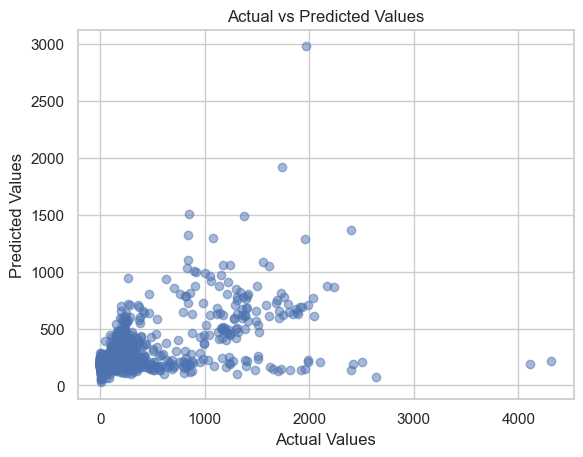

In [290]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

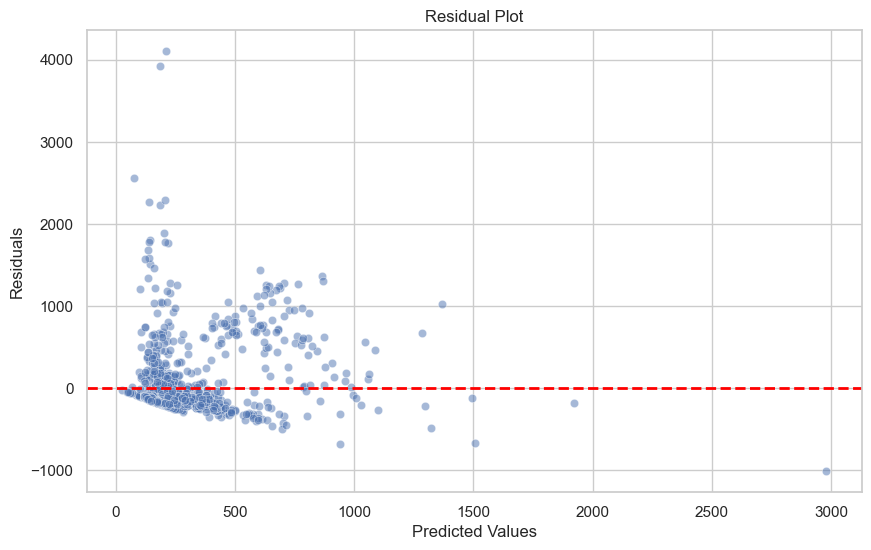

In [291]:
import seaborn as sns

# Calculate residuals
residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

## Bagging

In [309]:
from sklearn.ensemble import RandomForestRegressor as RFR

regr = RFR(n_estimators=300, max_depth = 25, max_features="sqrt", random_state=42)

regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, max_features='sqrt', n_estimators=300,
                      random_state=42)

In [310]:
predictions = regr.predict(X_test)
# Display the results
print(f"Mean Absolute Error on df_test: {mae(y_test, predictions):.2f}")

print('Mean squared error:')
print(mean_squared_error(y_test, predictions))

print('R2 score of test')
print(r2_score(y_test, predictions))

print('R2 score of train')
print(r2_score(y_train, regr.predict(X_train)))

Mean Absolute Error on df_test: 247.56
Mean squared error:
139891.34081778972
R2 score of test
0.24419873769558864
R2 score of train
0.9481386675343318


Grid Search for Random Forest

In [328]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, scoring='neg_mean_absolute_percentage_error', verbose = 3)
grid_search.fit(X_train, y_train)

predictions = grid_search.best_estimator_.predict(X_test)
pred_train = grid_search.best_estimator_.predict(X_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

print(f"Mean Absolute Error on df_test: {mae(y_test, predictions):.2f}")

print('Mean squared error:')
print(mean_squared_error(y_test, predictions))

print('R2 score of test')
print(r2_score(y_test, predictions))

print('R2 score of train')
print(r2_score(y_train, pred_train))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-3946188260978348.500 total time=   0.1s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-1722787234151301.500 total time=   0.1s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-10207228567498206.000 total time=   0.1s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-18618965218947484.000 total time=   0.1s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-28288779518605088.000 total time=   0.1s
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-4066764626853438.500 total time=   0.4s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-1694146753609282.000 total time=   0.

In [344]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Generate all possible combinations of parameters
param_combinations = list(ParameterGrid(param_grid))

df_train = df_prophet[df_prophet.ds <= pd.to_datetime("15.03.2018")]
df_test = df_prophet[df_prophet.ds > pd.to_datetime("15.03.2018")]

# Function to fit a Prophet model and return the MAE
def fit_prophet(params, train_data, test_data):
    model = Prophet(**params)
    model.add_regressor("num_shares")
    model.add_regressor("status_type_link")
    model.add_regressor("status_type_photo")
    model.add_regressor("status_type_status")
    model.add_regressor("status_type_video")
    model.fit(train_data)

    forecast = model.predict(test_data.drop("y", axis = "columns"))
    test_points = pd.merge(forecast, df_test, on = "ds")

    # remove everything below 0
    for col in ['yhat', 'yhat_lower', 'yhat_upper']:
        test_points[col] = test_points[col].clip(lower=0.0)

    # Evaluate using MAE
    mae_temp = mae(test_points['y'], test_points['yhat'])

    return mae_temp

# Perform grid search
best_mae = float('inf')
best_params = None

for params in param_combinations:
    mae_temp = fit_prophet(params, df_train, df_test)

    if mae_temp < best_mae:
        best_mae = mae_temp
        best_params = params

print("Best Parameters:", best_params)
print("Best MAE:", best_mae)

# Train the final model on the entire dataset with the best parameters
final_model = Prophet(**best_params)
final_model.add_regressor("num_shares")
final_model.add_regressor("status_type_link")
final_model.add_regressor("status_type_photo")
final_model.add_regressor("status_type_status")
final_model.add_regressor("status_type_video")
final_model.fit(df_train)

C:\Users\User\AppData\Local\Temp\ipykernel_13896\167524999.py:11: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_13896\167524999.py:12: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

22:43:18 - cmdstanpy - INFO - Chain [1] start processing
22:43:18 - cmdstanpy - INFO - Chain [1] done processing
22:43:19 - cmdstanpy - INFO - Chain [1] start processing
22:43:19 - cmdstanpy - INFO - Chain [1] done processing
22:43:20 - cmdstanpy - INFO - Chain [1] start processing
22:43:20 - cmdstanpy - INFO - Chain [1] done processing
22:43:21 - cmdstanpy - INFO - Chain [1] start processing
22:43:22 - cmdstanpy - INFO - Chain [1] done processing
22:43:23 - cmdstanpy - INFO - Chain [1] start processing
22:43:24 - cmdstanpy - INFO - Cha

Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}
Best MAE: 182.79076525425447


22:43:36 - cmdstanpy - INFO - Chain [1] start processing
22:43:38 - cmdstanpy - INFO - Chain [1] done processing


In [345]:
# make the datasets for plotting the results
forecast = final_model.predict(df_test.drop("y", axis = "columns"))
forecast2 = final_model.predict(pd.merge(m.make_future_dataframe(periods=0), df_prophet).drop("y", axis = "columns"))
test_points = pd.merge(forecast, df_test, on = "ds")
train_points = pd.merge(forecast2, df_train, on = "ds")

# remove everything below 0
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_points[col] = test_points[col].clip(lower=0.0)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_points[col] = train_points[col].clip(lower=0.0)

Text(0.5, 1.0, 'Prediction of Number of Reactions')

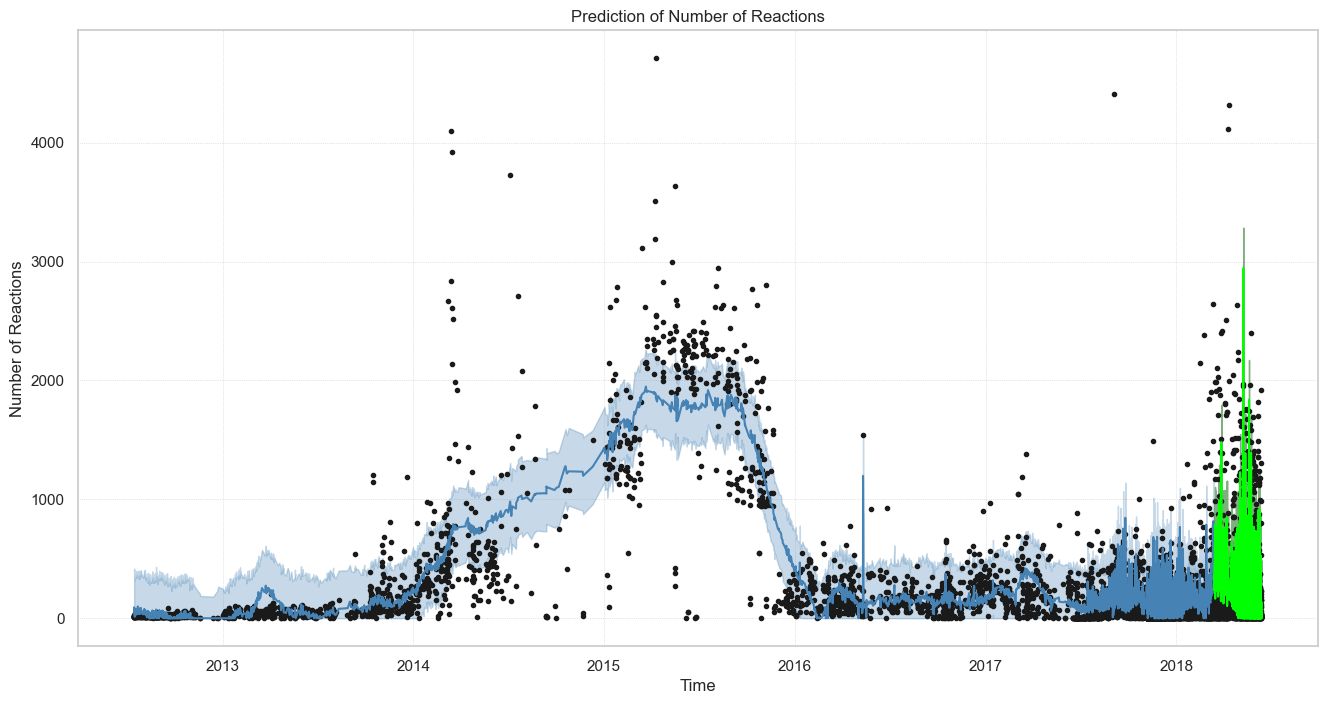

In [346]:
f, ax = plt.subplots(figsize=(16, 8))
ax.plot(train_points.ds, train_points.y, 'ko', markersize=3)
ax.plot(train_points.ds, train_points.yhat, color='steelblue', lw=1.5)
ax.fill_between(train_points.ds, train_points.yhat_lower, train_points.yhat_upper, color='steelblue', alpha=0.3)
ax.plot(test_points.ds, test_points.y, 'ko', markersize=3)
ax.plot(test_points.ds, test_points.yhat, color='lime', lw=1.5)
ax.fill_between(test_points.ds, test_points.yhat_lower, test_points.yhat_upper, color='darkgreen', alpha=0.5)
ax.grid(ls=':', lw=0.5)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Reactions")
ax.set_title("Prediction of Number of Reactions")

In [347]:
mae(test_points.y, test_points.yhat)
mean_squared_error(test_points.y, test_points.yhat)
r2_score(test_points.y, test_points.yhat)

print(f"Mean Absolute Error on df_test: {mae(test_points.y, test_points.yhat):.2f}")

print(f'Mean squared error: {mean_squared_error(test_points.y, test_points.yhat):.2f}')

print(f'R2 score: {r2_score(test_points.y, test_points.yhat):.2f}')
print(f'R2 score of train: {r2_score(train_points.y, train_points.yhat):.2f}')

Mean Absolute Error on df_test: 182.79
Mean squared error: 138936.57
R2 score: 0.25
R2 score of train: 0.71
